In [1]:
#%% -------- 1. Imports & Configuration --------
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import joblib
import seaborn as sns
from skimage import io, feature
from skimage.transform import resize
from skimage.filters import gabor
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_curve, roc_auc_score, accuracy_score)
from imblearn.over_sampling import SMOTE

In [2]:
#%% -------- 2. Configuration --------
IMG_SIZE = (650, 325)  # Reduced size for computational efficiency
TARGET_NAMES = ['female', 'male']
DATA_PATHS = {
    'train': "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\train",
    'valid': "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\val",
    'test': "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test"
}

In [3]:
#%% -------- 2. Metaheuristic Feature Selectors --------
class PSOFeatureSelector:
    def __init__(self, n_particles=20, iterations=50, phi1=1.5, phi2=1.5):
        self.n_particles = n_particles
        self.iterations = iterations
        self.phi1 = phi1
        self.phi2 = phi2
        self.best_features = None
        
    def optimize(self, X, y):
        n_features = X.shape[1]
        particles = np.random.rand(self.n_particles, n_features)
        velocities = np.zeros_like(particles)
        pbest = particles.copy()
        pbest_scores = np.zeros(self.n_particles)
        gbest = None
        gbest_score = 0
        
        for i in range(self.n_particles):
            score = self._fitness(X, y, particles[i])
            pbest_scores[i] = score
            if score > gbest_score:
                gbest_score = score
                gbest = particles[i].copy()
                
        for _ in range(self.iterations):
            for i in range(self.n_particles):
                r1, r2 = np.random.rand(2)
                velocities[i] += self.phi1*r1*(pbest[i] - particles[i]) + \
                                self.phi2*r2*(gbest - particles[i])
                particles[i] = 1/(1+np.exp(-velocities[i]))
                
                score = self._fitness(X, y, particles[i])
                if score > pbest_scores[i]:
                    pbest_scores[i] = score
                    pbest[i] = particles[i].copy()
                    if score > gbest_score:
                        gbest_score = score
                        gbest = particles[i].copy()
                        
        self.best_features = gbest > 0.5
        return self.best_features
    
    def _fitness(self, X, y, particle):
        mask = particle > 0.5
        if sum(mask) == 0: return 0
        return cross_val_score(LogisticRegression(), X[:,mask], y, 
                             cv=3, scoring='accuracy').mean()

class GWOFeatureSelector:
    def __init__(self, n_wolves=20, iterations=50):
        self.n_wolves = n_wolves
        self.iterations = iterations
        self.best_features = None
        
    def optimize(self, X, y):
        n_features = X.shape[1]
        wolves = np.random.rand(self.n_wolves, n_features)
        alpha = beta = delta = None
        alpha_score = beta_score = delta_score = -np.inf
        
        for _ in range(self.iterations):
            scores = [self._fitness(X, y, wolf) for wolf in wolves]
            for i, score in enumerate(scores):
                if score > alpha_score:
                    alpha_score, beta_score, delta_score = score, alpha_score, beta_score
                    alpha, beta, delta = wolves[i].copy(), alpha, beta
                elif score > beta_score:
                    beta_score, delta_score = score, beta_score
                    beta, delta = wolves[i].copy(), beta
                elif score > delta_score:
                    delta_score = score
                    delta = wolves[i].copy()
                    
            a = 2 - 2*(_/self.iterations)
            for i in range(self.n_wolves):
                A1, A2, A3 = a*(2*np.random.rand(3)-1)
                D_alpha = np.abs(A1*alpha - wolves[i])
                D_beta = np.abs(A2*beta - wolves[i])
                D_delta = np.abs(A3*delta - wolves[i])
                X1 = alpha - A1*D_alpha
                X2 = beta - A2*D_beta
                X3 = delta - A3*D_delta
                wolves[i] = (X1 + X2 + X3)/3
                
        self.best_features = alpha > 0.5
        return self.best_features
    
    def _fitness(self, X, y, wolf):
        mask = wolf > 0.5
        if sum(mask) == 0: return 0
        return cross_val_score(LogisticRegression(), X[:,mask], y,
                             cv=3, scoring='accuracy').mean()

In [4]:
#%% -------- 3. Enhanced Feature Extraction --------
class DentalFeatureExtractor:
    def __init__(self):
        self.hog_params = {
            'orientations': 9,
            'pixels_per_cell': (32, 32),
            'cells_per_block': (2, 2)
        }
        
    def extract_features(self, img):
        img_resized = resize(img, IMG_SIZE, anti_aliasing=True)
        
        # HOG Features
        hog = feature.hog(img_resized, **self.hog_params)
        
        # GLCM Features
        glcm = graycomatrix((img_resized*255).astype(np.uint8), 
                           distances=[1,3], angles=[0, np.pi/4, np.pi/2],
                           symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast').ravel()
        dissimilarity = graycoprops(glcm, 'dissimilarity').ravel()
        homogeneity = graycoprops(glcm, 'homogeneity').ravel()
        energy = graycoprops(glcm, 'energy').ravel()
        
        # Gabor Features
        gabor_feats = []
        for freq in [0.1, 0.3, 0.5]:
            for theta in np.linspace(0, np.pi, 4):
                real, _ = gabor(img_resized, frequency=freq, theta=theta)
                gabor_feats.extend([real.mean(), real.std()])
                
        return np.concatenate([hog, contrast, dissimilarity,
                              homogeneity, energy, gabor_feats])

In [5]:
#%% -------- 4. Data Pipeline --------
import os
def load_data(folder):
    extractor = DentalFeatureExtractor()
    features, labels = [], []
    for label in TARGET_NAMES:
        path = f"{folder}/{label.lower()}"
        for file in os.listdir(path):
            img = io.imread(f"{path}/{file}", as_gray=True)
            features.append(extractor.extract_features(img))
            labels.append(label)
    return np.array(features), np.array(labels)

# Load datasets
X_train, y_train = load_data(DATA_PATHS['train'])
X_valid, y_valid = load_data(DATA_PATHS['valid'])
X_test, y_test = load_data(DATA_PATHS['test'])

# Combine and balance data
X_full = np.vstack([X_train, X_valid])
y_full = np.concatenate([y_train, y_valid])
X_full, y_full = SMOTE().fit_resample(X_full, y_full)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y_full)
y_test_enc = le.transform(y_test)

In [6]:
#%% -------- 5. Feature Selection --------
# Optimize with PSO
pso = PSOFeatureSelector(n_particles=30, iterations=50)
selected_mask = pso.optimize(X_full, y_enc)
X_selected = X_full[:, selected_mask]
print(f"Selected {sum(selected_mask)} features from {X_full.shape[1]}")

# Optional: Combine with GWO
gwo = GWOFeatureSelector(n_wolves=30, iterations=50)
selected_mask = gwo.optimize(X_selected, y_enc)
X_selected = X_selected[:, selected_mask]

Selected 3048 features from 6204


In [11]:
#%% -------- 6. Optimized Model Pipeline --------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('clf', LogisticRegression(class_weight='balanced', solver='saga',
                              max_iter=2000, penalty='l2', C=0.1))
])

# Cross-validation
cv_scores = cross_val_score(pipeline, X_selected, y_enc, 
                           cv=KFold(5, shuffle=True), scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.2%} ± {cv_scores.std():.2%}")

# Fit pipeline on the full training data after cross-validation
pipeline.fit(X_selected, y_enc)

# Apply feature selection to test data
X_test_pso = X_test[:, pso.best_features]  # Apply PSO mask
X_test_selected = X_test_pso[:, gwo.best_features]  # Apply GWO mask

# Make predictions on processed test data
test_pred = pipeline.predict(X_test_selected)
test_proba = pipeline.predict_proba(X_test_selected)[:, 1]

CV Accuracy: 94.90% ± 1.40%



Test Accuracy: 94.85%
AUC-ROC: 98.68%


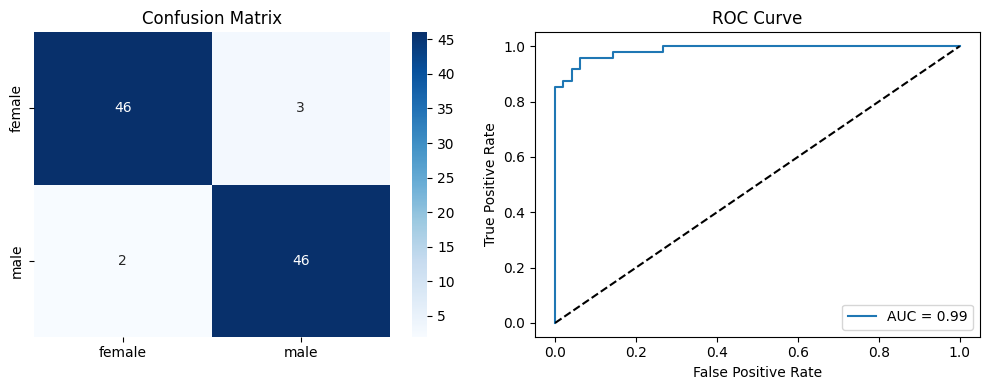

In [12]:
#%% -------- 7. Evaluation & Visualization --------
print(f"\nTest Accuracy: {accuracy_score(y_test_enc, test_pred):.2%}")
print(f"AUC-ROC: {roc_auc_score(y_test_enc, test_proba):.2%}")

plt.figure(figsize=(10,4))
plt.subplot(121)
sns.heatmap(confusion_matrix(y_test_enc, test_pred), 
            annot=True, fmt='d', cmap='Blues', xticklabels=TARGET_NAMES,
            yticklabels=TARGET_NAMES)
plt.title("Confusion Matrix")

plt.subplot(122)
fpr, tpr, _ = roc_curve(y_test_enc, test_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test_enc, test_proba):.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

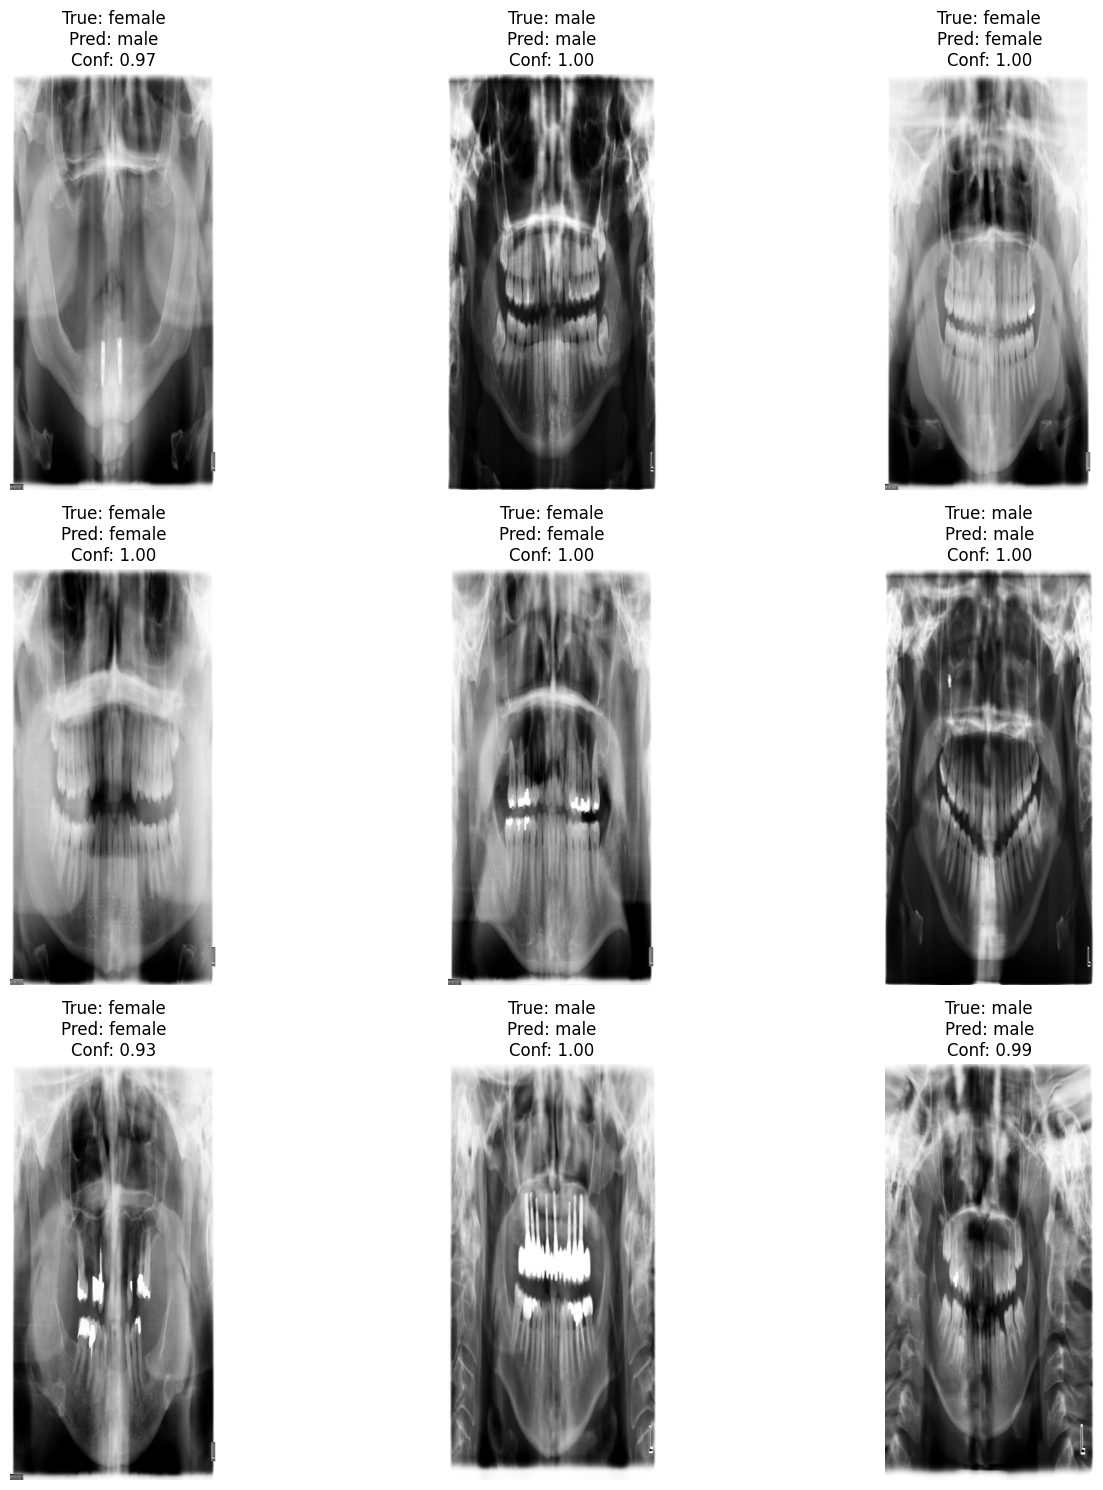

In [15]:
#%% -------- 8. Inference Visualization Cell --------
def predict_and_visualize(test_dir, num_images=9):
    # Load model components
    model_data = joblib.load('gender_classifier.pkl')
    pso = model_data['pso_selector']
    gwo = model_data['gwo_selector']
    le = model_data['label_encoder']
    pipeline = model_data['pipeline']
    extractor = DentalFeatureExtractor()
    
    # Get all test images paths and labels
    image_paths = []
    true_labels = []
    for label in TARGET_NAMES:
        label_dir = os.path.join(test_dir, label.lower())
        for fname in os.listdir(label_dir):
            image_paths.append(os.path.join(label_dir, fname))
            true_labels.append(label)
    
    # Random selection
    selected_indices = np.random.choice(len(image_paths), size=num_images, replace=False)
    
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(selected_indices):
        img_path = image_paths[idx]
        true_label = true_labels[idx]
        
        # Load and preprocess image
        img = io.imread(img_path, as_gray=True)
        img_resized = resize(img, IMG_SIZE, anti_aliasing=True)
        
        # Extract features and select
        features = extractor.extract_features(img_resized)
        features_pso = features[pso.best_features]
        features_selected = features_pso[gwo.best_features]
        
        # Make prediction
        proba = pipeline.predict_proba([features_selected])[0]
        pred_label = pipeline.predict([features_selected])[0]
        pred_class = le.inverse_transform([pred_label])[0]
        confidence = proba.max()
        
        # Plot results
        plt.subplot(3, 3, i+1)
        plt.imshow(img_resized, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_class}\nConf: {confidence:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage
predict_and_visualize(DATA_PATHS['test'])